In [1]:
cd /content/drive/MyDrive/논문/DCN

/content/drive/MyDrive/논문/DCN


In [2]:
ls

1220_dcn.ipynb           train_v2_201130.json  Wine_segment_201229.csv
1227_DCN_practive.ipynb  user_test_v2.json     Wine_segment_scaled_201231.csv
test_v2_201130.json      user_train_v2.json


In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 3.6MB 10.8MB/s 


In [4]:
import os
import sys
import gc
import glob
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

# 0. Data Load

In [5]:
# 0. Data Load

In [6]:
train = pd.read_json('train_v2_201130.json')
test = pd.read_json('test_v2_201130.json')

In [7]:
train.head()

index  ... like
0      0  ...    1
1      1  ...    1
2      4  ...    1
3      5  ...    1
4      6  ...    0

[5 rows x 10 columns]

In [8]:
train.shape, test.shape

((763387, 10), (188718, 10))

In [9]:
item = pd.read_csv('Wine_segment_201229.csv')

In [10]:
item.head()

wine_id                        name  ...  winery_id  segment
0  1938520     1882 Cabernet Sauvignon  ...     2412.0        2
1    14604      Les Bessards Hermitage  ...     7636.0        2
2  1930757      Patriarch Estate Grown  ...     1905.0        2
3  1564280                      Merlot  ...     1297.0        2
4  2576427  Cabernet Sauvignon F Block  ...     2232.0        2

[5 rows x 152 columns]

# 1. Data Preprocess

In [11]:
train = train[['userID', 'wine_id', 'rating_per_user', 'like']]
test = test[['userID', 'wine_id', 'rating_per_user', 'like']]

In [12]:
selected_item = item[[
      'wine_id',
      'rating_count',
      'rating_average',
      'review_count',
      'label_count',
      'body',
      'acidity_y',
      'alcohol',
      'type_id',
      'grapes_id',
      'country_code',
      'region_id',
      'segment'
]]

selected_item

wine_id  rating_count  rating_average  ...  country_code  region_id  segment
0      1938520          1697             4.1  ...            us      105.0        2
1        14604          1078             4.3  ...            fr      535.0        2
2      1930757          1072             4.6  ...            us       88.0        2
3      1564280          3577             4.3  ...            us       24.0        2
4      2576427           115             4.4  ...            us       42.0        2
...        ...           ...             ...  ...           ...        ...      ...
50855  1669561           788             3.5  ...            it      983.0        1
50856  1861275           231             3.8  ...            it      613.0        1
50857  2201892           390             3.9  ...            it     3232.0        1
50858  2396179           302             4.2  ...            fr      635.0        3
50859  7715684            82             4.1  ...            es     1687.0        2

[50860 rows x 13 columns]

In [13]:
train.loc[train['wine_id'] == 1886805, 'wine_id'] = 1183966
test.loc[test['wine_id'] == 1886805, 'wine_id'] = 1183966

In [14]:
add_train = train.merge(selected_item, on = 'wine_id', how = 'left')
add_test = test.merge(selected_item, on = 'wine_id', how = 'left')

add_train

userID  wine_id  rating_per_user  ...  country_code  region_id  segment
0       19484511  1141133              4.0  ...            fr      409.0        3
1         352674  1141133              4.0  ...            fr      409.0        3
2       17786617  1141133              4.0  ...            fr      409.0        3
3        8078038  1141133              4.5  ...            fr      409.0        3
4        3014532  1141133              4.0  ...            fr      409.0        3
...          ...      ...              ...  ...           ...        ...      ...
763382  11274168    87064              3.0  ...            es      766.0        1
763383  11274168    63654              4.0  ...            fr      387.0        3
763384  11274168     5602              4.5  ...            us       96.0        3
763385  11274168  1396664              3.0  ...            us       25.0        2
763386  11274168  1142712              3.5  ...            us      327.0        2

[763387 rows x 16 columns]

In [15]:
add_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763387 entries, 0 to 763386
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userID           763387 non-null  int64  
 1   wine_id          763387 non-null  int64  
 2   rating_per_user  763387 non-null  float64
 3   like             763387 non-null  int64  
 4   rating_count     763387 non-null  int64  
 5   rating_average   763387 non-null  float64
 6   review_count     763387 non-null  int64  
 7   label_count      763387 non-null  int64  
 8   body             763387 non-null  float64
 9   acidity_y        763387 non-null  float64
 10  alcohol          763387 non-null  float64
 11  type_id          763387 non-null  int64  
 12  grapes_id        763387 non-null  object 
 13  country_code     763387 non-null  object 
 14  region_id        763387 non-null  float64
 15  segment          763387 non-null  int64  
dtypes: float64(6), int64(8), object(2)
mem

In [16]:
add_train.isnull().sum()

userID             0
wine_id            0
rating_per_user    0
like               0
rating_count       0
rating_average     0
review_count       0
label_count        0
body               0
acidity_y          0
alcohol            0
type_id            0
grapes_id          0
country_code       0
region_id          0
segment            0
dtype: int64

In [17]:
add_train.head()

userID  wine_id  rating_per_user  ...  country_code  region_id  segment
0  19484511  1141133              4.0  ...            fr      409.0        3
1    352674  1141133              4.0  ...            fr      409.0        3
2  17786617  1141133              4.0  ...            fr      409.0        3
3   8078038  1141133              4.5  ...            fr      409.0        3
4   3014532  1141133              4.0  ...            fr      409.0        3

[5 rows x 16 columns]

# 2. Data Setting

In [18]:
str_features = ['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment']
int_features = ['rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol', 'like']
feature_names = str_features + int_features

In [19]:
def setType(df):

  df['rating_average'] = df['rating_average'].apply(lambda x : x * 10)
  df['acidity_y'] = df['acidity_y'].apply(lambda x : x * 10)
  df['grapes_id'] = df['grapes_id'].apply(lambda x : x[0])

  for f in str_features:
    if df[f].dtype == float:
      df[f] = df[f].astype(int)


  for f in int_features:
    df[f] = df[f].astype(int)

  return df

In [20]:
add_train = setType(add_train)
add_test = setType(add_test)

In [21]:
add_train

userID  wine_id  rating_per_user  ...  country_code  region_id  segment
0       19484511  1141133              4.0  ...            fr        409        3
1         352674  1141133              4.0  ...            fr        409        3
2       17786617  1141133              4.0  ...            fr        409        3
3        8078038  1141133              4.5  ...            fr        409        3
4        3014532  1141133              4.0  ...            fr        409        3
...          ...      ...              ...  ...           ...        ...      ...
763382  11274168    87064              3.0  ...            es        766        1
763383  11274168    63654              4.0  ...            fr        387        3
763384  11274168     5602              4.5  ...            us         96        3
763385  11274168  1396664              3.0  ...            us         25        2
763386  11274168  1142712              3.5  ...            us        327        2

[763387 rows x 16 columns]

In [22]:
train_str_dict = {
    str_feature: [str(val).encode() for val in add_train[str_feature].values]
    for str_feature in str_features
}

train_int_dict = {
    int_feature: add_train[int_feature].values
    for int_feature in int_features
}

train_label_dict = {
    'rating_per_user' : add_train['rating_per_user'].values
}

train_str_dict.update(train_int_dict)
train_str_dict.update(train_label_dict)
train_str_dict.keys()

dict_keys(['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment', 'rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol', 'like', 'rating_per_user'])

In [23]:
test_str_dict = {
    str_feature: [str(val).encode() for val in add_test[str_feature].values]
    for str_feature in str_features
}

test_int_dict = {
    int_feature: add_test[int_feature].values
    for int_feature in int_features
}

test_label_dict = {
    'rating_per_user' : add_test['rating_per_user'].values
}

test_str_dict.update(test_int_dict)
test_str_dict.update(test_label_dict)
test_str_dict.keys()

dict_keys(['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment', 'rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol', 'like', 'rating_per_user'])

In [24]:
tensor_train = tf.data.Dataset.from_tensor_slices(train_str_dict)
tensor_test = tf.data.Dataset.from_tensor_slices(test_str_dict)

In [25]:
vocabularies = {}

for feature_name in tqdm(feature_names):
  vocab = tensor_train.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

100%|██████████| 15/15 [01:51<00:00,  7.41s/it]


In [26]:
vocabularies

{'acidity_y': array([ 0,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75]),
 'alcohol': array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  45,  80, 112, 114,
        135]),
 'body': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'country_code': array([b'al', b'am', b'ar', b'at', b'au', b'be', b'bg', b'bo', b'br',
        b'ca', b'ch', b'cl', b'cn', b'cy', b'cz', b'de', b'dk', b'es',
        b'fr', b'gb', b'ge', b'gr', b'hr', b'hu', b'il', b'in', b'it',
        b'jp', b'lb', b'lu', b'ma', b'md', b'me', b'mk', b'mt', b'mx',
        b'nl', b'nz', b'pe', b'ps', b'pt', b'ro', b'rs', b'ru', b'se',
        b'si', b'sk', b'th', b'tn', b'tr', b'ua', b'unk', b'us', b'uy',
        b'za'], dtype=object),
 'gra

In [27]:
import ast
add_train['grapes_id'] = add_train['grapes_id'].apply(lambda x : '[]' if x == '0' else x)
grapes =[]
add_train['grapes_id'].apply(lambda x : grapes.extend(ast.literal_eval(x)))
add_train['grapes_id'] = add_train['grapes_id'].apply(lambda x : ast.literal_eval(x))
grapes = list(set(grapes))
len(grapes)

718

In [28]:
vocabularies['grapes_id'] = tf.keras.preprocessing.sequence.pad_sequences(add_train['grapes_id'])

In [90]:
vocab_grapes_id = vocabularies['grapes_id']
vocabularies['grapes_id'] = [str(val).encode() for val in grapes]

In [93]:
vocabularies['grapes_id'] = np.array(vocabularies['grapes_id'])

# 3. Model

In [27]:
import tensorflow as tf
import keras
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}


class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [79]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 64

    str_features = ['userID', 'wine_id', 'type_id', 'country_code', 'region_id', 'segment', 'grapes_id']
    # emb_features = ['grapes_id']
    int_features = ['rating_count', 'rating_average', 'review_count', 'body', 'acidity_y', 'alcohol']
    # feature_names = str_features + int_features

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # grapes_id embedding
    # labels_embedding_layer = tf.keras.layers.Embedding(input_dim = 1740, output_dim = 50, 
    #                                         mask_zero=True, trainable=True, name='labels_embeddings')
    
    # avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')
    # l2_norm_1 = L2NormLayer(name='l2_norm_1')

    # input_grapes = vocabularies['grapes_id']
    # grapes_embeddings = labels_embedding_layer(input_grapes)
    # l2_norm_grapes = l2_norm_1(grapes_embeddings)
    # self._embeddings['grapes_id'] = tf.keras.Sequential(
    #     [avg_embeddings(l2_norm_grapes), tf.keras.layers.Embedding(1739 + 1, 
    #                                                               50)]
    # )

    # self._embeddings['grapes_id'] = avg_embeddings(l2_norm_grapes).flatten()


    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim = projection_dim,
          kernel_initializer = "glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      # loss=tf.keras.losses.MeanSquaredError(),
      loss = tf.keras.losses.BinaryCrossentropy(),
      metrics=[
              #  tf.keras.metrics.RootMeanSquaredError("RMSE")
               tf.keras.metrics.BinaryAccuracy(
                  name='binary_accuracy', dtype = None, threshold = 0.5)
               ]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("like")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [80]:
learning_rate = 0.001

cached_train = tensor_train.shuffle(100_000).batch(8192).cache()
cached_test = tensor_test.batch(4096).cache()

In [81]:
model = DCN(use_cross_layer = True,
            deep_layer_sizes = [256, 128, 64],
            projection_dim = 50)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate))

# 4. Train

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds

cached_test_numpy = tfds.as_numpy(cached_test)
y_true = [item['like'] for item in cached_test_numpy]
y_true = np.concatenate(y_true)

In [85]:
def get_result(model):
  y_pred = model.predict(cached_test).flatten()
  y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]

  print(f"ROC: {roc_auc_score(y_true, y_pred)}")
  print(classification_report(y_true, y_pred_class))

In [82]:
import keras
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                    monitor = 'binary_accuracy',
                    patience = 15
                  )
]

In [83]:
history = model.fit(cached_train,
                     epochs = 500,
                     callbacks = callbacks_list,
                     verbose = True)

Epoch 1/500
94/94 [==============================] - 21s 201ms/step - binary_accuracy: 0.6379 - loss: 0.6752 - regularization_loss: 0.0000e+00 - total_loss: 0.6752
Epoch 2/500
94/94 [==============================] - 7s 72ms/step - binary_accuracy: 0.7191 - loss: 0.5573 - regularization_loss: 0.0000e+00 - total_loss: 0.5573
Epoch 3/500
94/94 [==============================] - 7s 74ms/step - binary_accuracy: 0.7396 - loss: 0.5202 - regularization_loss: 0.0000e+00 - total_loss: 0.5202
Epoch 4/500
94/94 [==============================] - 7s 73ms/step - binary_accuracy: 0.7460 - loss: 0.5042 - regularization_loss: 0.0000e+00 - total_loss: 0.5042
Epoch 5/500
94/94 [==============================] - 7s 75ms/step - binary_accuracy: 0.7496 - loss: 0.4967 - regularization_loss: 0.0000e+00 - total_loss: 0.4967
Epoch 6/500
94/94 [==============================] - 7s 76ms/step - binary_accuracy: 0.7453 - loss: 0.4972 - regularization_loss: 0.0000e+00 - total_loss: 0.4972
Epoch 7/500
94/94 [=======

In [62]:
pred = model.predict(cached_test).flatten()

In [54]:
pd.DataFrame(zip(model.predict(cached_train), add_train['rating_per_user'].values))

0    1
0       [3.7662323]  4.0
1       [4.6074934]  4.0
2       [4.6604505]  4.0
3       [4.1400437]  4.5
4       [3.9927986]  4.0
...             ...  ...
763382  [3.8313277]  3.0
763383  [4.5237317]  4.0
763384   [4.633769]  4.5
763385   [4.361144]  3.0
763386  [3.0272295]  3.5

[763387 rows x 2 columns]

In [86]:
get_result(model)

ROC: 0.9448528879987997
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     88227
           1       0.91      0.91      0.91    100491

    accuracy                           0.90    188718
   macro avg       0.90      0.90      0.90    188718
weighted avg       0.90      0.90      0.90    188718



In [63]:
model.summary()

Model: "dcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 32)                2112      
_________________________________________________________________
sequential_12 (Sequential)   (None, 32)                896       
_________________________________________________________________
sequential_10 (Sequential)   (None, 32)                288       
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                1792      
_________________________________________________________________
sequential_3 (Sequential)    (None, 32)                96        
_________________________________________________________________
sequential_8 (Sequential)    (None, 32)                864       
_________________________________________________________________
sequential_7 (Sequential)    (None, 32)                254688  

In [64]:
pred = model.predict(cached_test)

In [78]:
def makeTEST(df, id):
  df['userID'] = id
  df['like'] = 0
  return df

In [79]:
temp = makeTEST(selected_item, 1201)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
add_temp = setType(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [82]:
temp_str_dict = {
    str_feature: [str(val).encode() for val in add_temp[str_feature].values]
    for str_feature in str_features
}

temp_int_dict = {
    int_feature: add_temp[int_feature].values
    for int_feature in int_features
}

temp_str_dict.update(temp_int_dict)
temp_str_dict.keys()

dict_keys(['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment', 'rating_count', 'rating_average', 'review_count', 'body', 'acidity_y', 'alcohol', 'like'])

In [83]:
tensor_temp = tf.data.Dataset.from_tensor_slices(temp_str_dict)

In [84]:
cached_temp = tensor_temp.batch(1024).cache()

In [86]:
pred = model.predict(cached_temp)
pred.shape

(50860, 1)

In [97]:
pred = pd.DataFrame(pred).sort_values(0, ascending = False)
pred.loc[pred[0] == 1]

0
38876  1.0
7629   1.0
19281  1.0
19278  1.0
19277  1.0
...    ...
16664  1.0
4318   1.0
4084   1.0
39069  1.0
13705  1.0

[1201 rows x 1 columns]

In [117]:
import seaborn as sns
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,15)})

In [119]:
features

ListWrapper(['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment', 'rating_count', 'rating_average', 'review_count', 'body', 'acidity_y', 'alcohol'])

<Figure size 1800x1800 with 0 Axes>

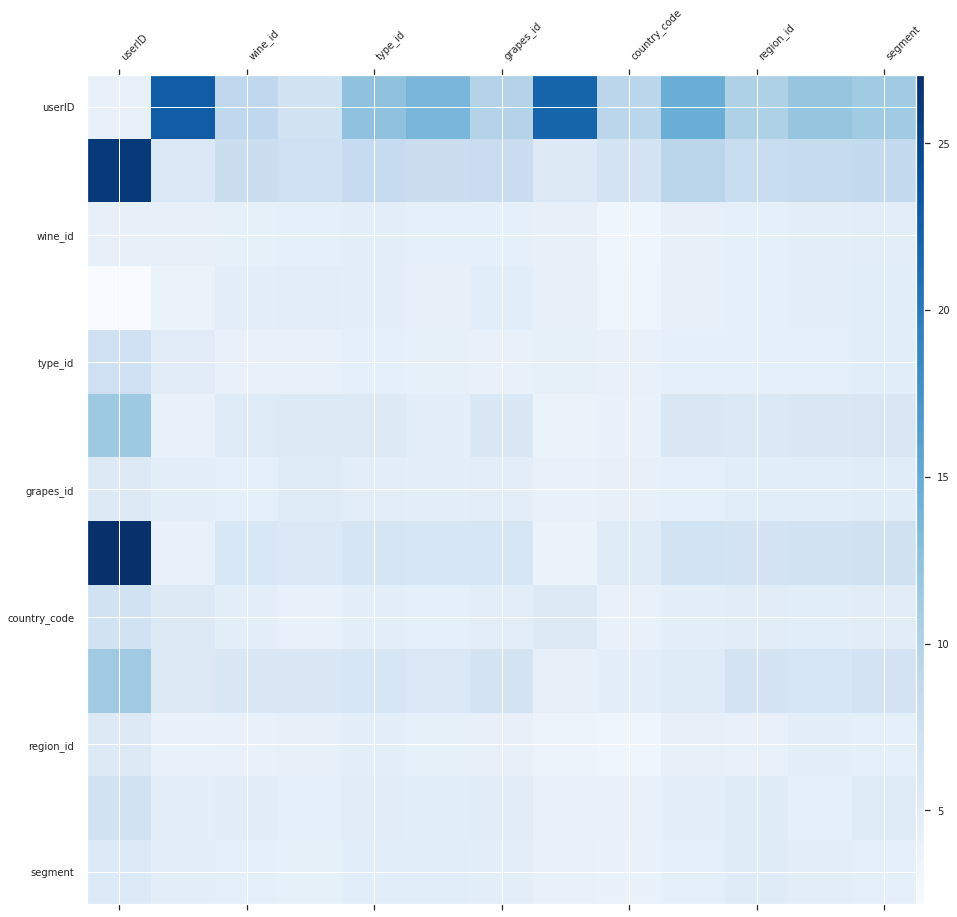

In [122]:
mat = model._cross_layer._dense.kernel
features = model._all_features
block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(25,25))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="1%", pad=0.001)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10)
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)